<a href="https://colab.research.google.com/github/HeroicKrishna160905/dallaman/blob/main/dallaman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dallaman_openloop

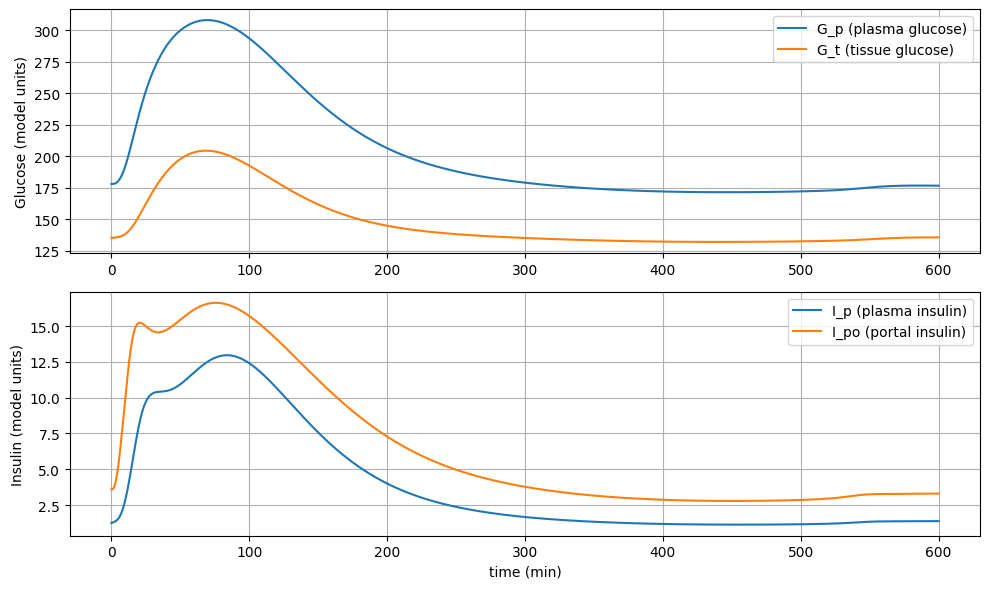

In [ ]:
"""
dallaman_openloop.py

Run with: python dallaman_openloop.py

Dependencies:
- numpy
- scipy
- matplotlib
"""
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def dallaman_ode(t, x, p):
    # x is vector of named states:
    # [Gp, Gt, Il, Ip, Qsto1, Qsto2, Qgut, I1, Id, X, I_po, Y]
    Gp, Gt, Il, Ip, Q_sto1, Q_sto2, Q_gut, I1, Id, X, I_po, Y = x

    # Unpack parameters
    V_G = p['V_G']
    k_1 = p['k_1']
    k_2 = p['k_2']
    G_b = p['G_b']
    V_I = p['V_I']
    m_1 = p['m_1']
    m_2 = p['m_2']
    m_4 = p['m_4']
    m_5 = p['m_5']
    m_6 = p['m_6']
    HE_b = p['HE_b']
    I_b = p['I_b']
    S_b = p['S_b']
    S_b_minus = p['S_b_minus']
    k_max = p['k_max']
    k_min = p['k_min']
    k_abs = p['k_abs']
    k_gri = p['k_gri']
    f = p['f']
    b = p['b']
    d = p['d']
    BW = p['BW']
    k_p1 = p['k_p1']
    k_p2 = p['k_p2']
    k_p3 = p['k_p3']
    k_p4 = p['k_p4']
    k_i = p['k_i']
    U_ii = p['U_ii']
    V_m0 = p['V_m0']
    V_mX = p['V_mX']
    K_m0 = p['K_m0']
    p_2U = p['p_2U']
    part = p['part']
    K = p['K']
    alpha = p['alpha']
    beta = p['beta']
    gamma = p['gamma']
    k_e1 = p['k_e1']
    k_e2 = p['k_e2']
    D = p['D']   # parameter used in gastric emptying scaling
    aa = 5/2/(1 - b) / D
    cc = 5/2 / d / D

    # Assign derived variables
    # EGP = k_p1 - k_p2*Gp - k_p3*Id - k_p4*I_po
    EGP = k_p1 - k_p2 * Gp - k_p3 * Id - k_p4 * I_po

    V_mmax = (1 - part) * (V_m0 + V_mX * X)
    U_idm = V_mmax * Gt / (K_m0 + Gt) if (K_m0 + Gt) != 0 else 0.0

    E = 0.0
    S = gamma * I_po
    I = Ip / V_I if V_I != 0 else 0.0
    G = Gp / V_G if V_G != 0 else 0.0

    HE = (-m_5) * S + m_6
    # prevent division by zero in m_3 computation if HE ~ 1:
    if abs(1 - HE) < 1e-8:
        m_3 = m_1 * 1e6
    else:
        m_3 = HE * m_1 / (1 - HE)

    Q_sto = Q_sto1 + Q_sto2
    Ra = f * k_abs * Q_gut / BW

    # gastric emptying nonlinear function (same tanh form as MATLAB)
    k_empt = k_min + (k_max - k_min) / 2.0 * (
        np.tanh(aa * (Q_sto - b * D)) - np.tanh(cc * (Q_sto - d * D)) + 2.0
    )

    U_id = U_idm
    U = U_ii + U_id

    # S_po as:
    S_po = Y + K * (EGP + Ra - E - U_ii - k_1 * Gp + k_2 * Gt) / V_G + S_b

    # Now the derivatives
    # dGp/dt
    dGp = EGP + Ra - E - U_ii - k_1 * Gp + k_2 * Gt
    # dGt/dt
    dGt = -U_id + k_1 * Gp - k_2 * Gt
    # dIl/dt
    dIl = (-m_1) * Il - m_3 * Il + m_2 * Ip + S
    # dIp/dt
    dIp = (-m_2) * Ip - m_4 * Ip + m_1 * Il
    # dQ_sto1/dt
    dQsto1 = -k_gri * Q_sto1
    # dQ_sto2/dt
    dQsto2 = -k_empt * Q_sto2 + k_gri * Q_sto1
    # dQ_gut/dt
    dQgut = -k_abs * Q_gut + k_empt * Q_sto2
    # dI1/dt
    dI1 = -k_i * (I1 - I)
    # dId/dt
    dId = -k_i * (Id - I1)
    # dX/dt
    dX = -p_2U * X + p_2U * (I - I_b)
    # dI_po/dt
    dIpo = -gamma * I_po + S_po
    # dY/dt
    dY = -alpha * (Y - beta * (G - G_b))

    return np.array([dGp, dGt, dIl, dIp, dQsto1, dQsto2, dQgut, dI1, dId, dX, dIpo, dY])

def run_simulation(t_span=(0, 600), dt=0.1):
    # parameters
    p = dict(
        V_G=1.88,
        k_1=0.065,
        k_2=0.079,
        G_b=95.0,
        V_I=0.05,
        m_1=0.19,
        m_2=0.484,
        m_4=0.194,
        m_5=0.0304,
        m_6=0.6471,
        HE_b=0.6,
        I_b=25.0,
        S_b=1.8,
        S_b_minus=-1.8,
        k_max=0.0558,
        k_min=0.008,
        k_abs=0.057,
        k_gri=0.0558,
        f=0.9,
        b=0.82,
        d=0.01,
        BW=78.0,
        k_p1=2.7,
        k_p2=0.0021,
        k_p3=0.009,
        k_p4=0.0618,
        k_i=0.0079,
        U_ii=1.0,
        V_m0=2.5,
        V_mX=0.047,
        K_m0=225.59,
        p_2U=0.0331,
        part=0.2,
        K=2.3,
        alpha=0.05,
        beta=0.11,
        gamma=0.5,
        k_e1=5.0e-4,
        k_e2=339.0,
        D=78000.0
    )

    # initial states ( we use named 12 states)
    x0 = np.array([
        178.0,  # Gp
        135.0,  # Gt
        4.5,    # Il
        1.25,   # Ip
        78000.0,# Q_sto1
        0.0,    # Q_sto2
        0.0,    # Q_gut
        25.0,   # I1
        25.0,   # Id
        0.0,    # X
        3.6,    # I_po
        0.0     # Y
    ])

    t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

    sol = solve_ivp(lambda t, x: dallaman_ode(t, x, p),
                    t_span, x0, t_eval=t_eval, method='RK45', atol=1e-6, rtol=1e-6)

    return sol, p

def plot_solution(sol):
    t = sol.t
    Gp = sol.y[0, :]
    Gt = sol.y[1, :]
    Ip = sol.y[3, :]
    Ipo = sol.y[10, :]

    plt.figure(figsize=(10, 6))
    plt.subplot(2,1,1)
    plt.plot(t, Gp / 1.0, label='G_p (plasma glucose)')  # units as in SBML
    plt.plot(t, Gt / 1.0, label='G_t (tissue glucose)')
    plt.ylabel('Glucose (model units)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(t, Ip, label='I_p (plasma insulin)')
    plt.plot(t, Ipo, label='I_po (portal insulin)')
    plt.xlabel('time (min)')
    plt.ylabel('Insulin (model units)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    sol, p = run_simulation((0, 600), dt=0.5)  # simulate 10 hours
    plot_solution(sol)


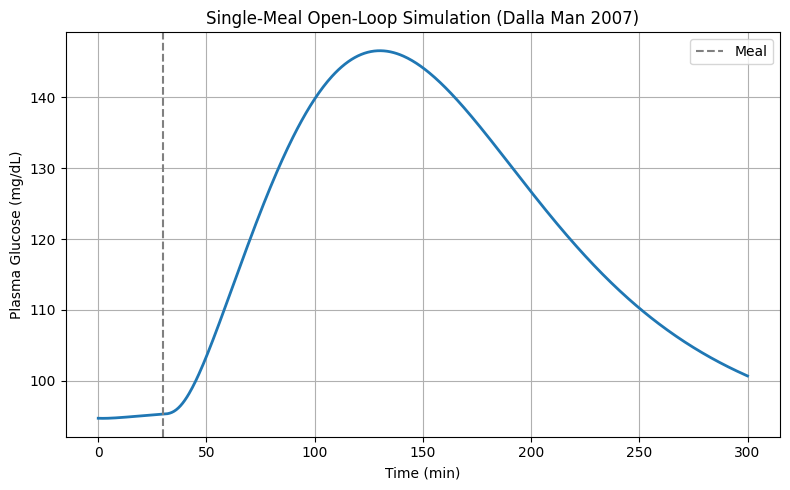

In [ ]:
# -------- Clean single-meal open-loop simulation  --------

# 1) Start from fasting steady state (no meal in stomach)
x0_fasting = np.array([
    178.0,  # Gp  -> ~95 mg/dL after division by V_G
    135.0,  # Gt
    4.5,    # Il
    1.25,   # Ip
    0.0,    # Q_sto1
    0.0,    # Q_sto2
    0.0,    # Q_gut
    25.0,   # I1
    25.0,   # Id
    0.0,    # X
    3.6,    # I_po
    0.0     # Y
])

# 2) Simulation settings
t_start = 0.0
t_end = 300.0          # 5 hours
dt = 0.5
t_eval = np.arange(t_start, t_end + dt, dt)

meal_time = 30.0       # minutes
meal_size = 60000.0    # mg glucose (~60 g CHO)

# 3) First simulate fasting until meal time
sol1 = solve_ivp(
    lambda t, x: dallaman_ode(t, x, p),
    [t_start, meal_time],
    x0_fasting,
    t_eval=np.arange(t_start, meal_time + dt, dt),
    rtol=1e-6, atol=1e-6
)

# 4) Inject meal into stomach compartment Q_sto1
x_meal = sol1.y[:, -1].copy()
x_meal[4] += meal_size   # Q_sto1 += meal

# 5) Continue simulation after meal
sol2 = solve_ivp(
    lambda t, x: dallaman_ode(t, x, p),
    [meal_time, t_end],
    x_meal,
    t_eval=np.arange(meal_time, t_end + dt, dt),
    rtol=1e-6, atol=1e-6
)

# 6) Concatenate results
t = np.concatenate([sol1.t, sol2.t])
Gp = np.concatenate([sol1.y[0], sol2.y[0]])

# Convert to plasma glucose concentration (mg/dL)
G = Gp / p['V_G']

# 7) Plot (paper-style)
plt.figure(figsize=(8, 5))
plt.plot(t, G, linewidth=2)
plt.axvline(meal_time, color='gray', linestyle='--', label='Meal')
plt.xlabel('Time (min)')
plt.ylabel('Plasma Glucose (mg/dL)')
plt.title('Single-Meal Open-Loop Simulation (Dalla Man 2007)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


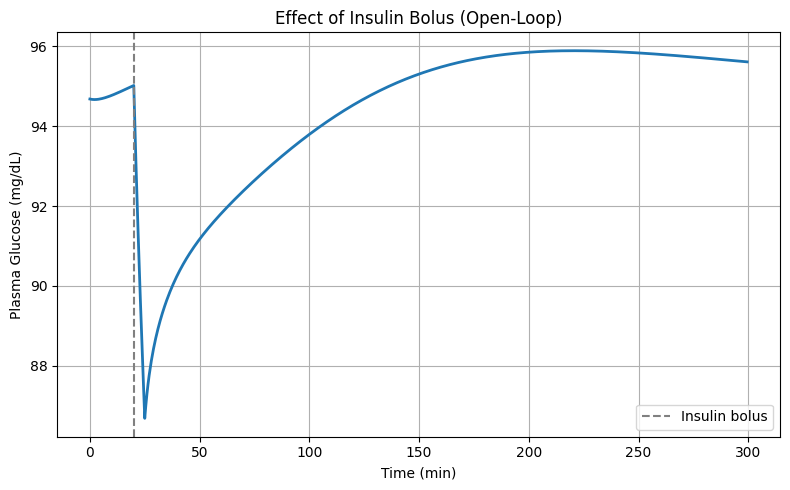

In [ ]:
# -------- Test impact of insulin infusion (bolus) --------

# Time-varying insulin infusion
def insulin_infusion(t):
    basal = 1.0          # baseline U_ii
    bolus_time = 20.0    # min
    bolus_amount = 4.0  # insulin units (model scale)
    bolus_width = 5.0   # min

    # simple square bolus
    if bolus_time <= t <= bolus_time + bolus_width:
        return basal + bolus_amount
    return basal


def dallaman_ode_with_insulin(t, x, p):
    p_mod = p.copy()
    p_mod['U_ii'] = insulin_infusion(t)
    return dallaman_ode(t, x, p_mod)


# Fasting initial state
x0 = x0_fasting.copy()

# Simulation settings
t_eval = np.arange(0, 300, 0.5)

# Run simulation
sol = solve_ivp(
    lambda t, x: dallaman_ode_with_insulin(t, x, p),
    [0, 300],
    x0,
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-6
)

# Extract glucose
Gp = sol.y[0]
G = Gp / p['V_G']

# Plot glucose
plt.figure(figsize=(8, 5))
plt.plot(sol.t, G, linewidth=2)
plt.axvline(20, linestyle='--', color='gray', label='Insulin bolus')
plt.xlabel('Time (min)')
plt.ylabel('Plasma Glucose (mg/dL)')
plt.title('Effect of Insulin Bolus (Open-Loop)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


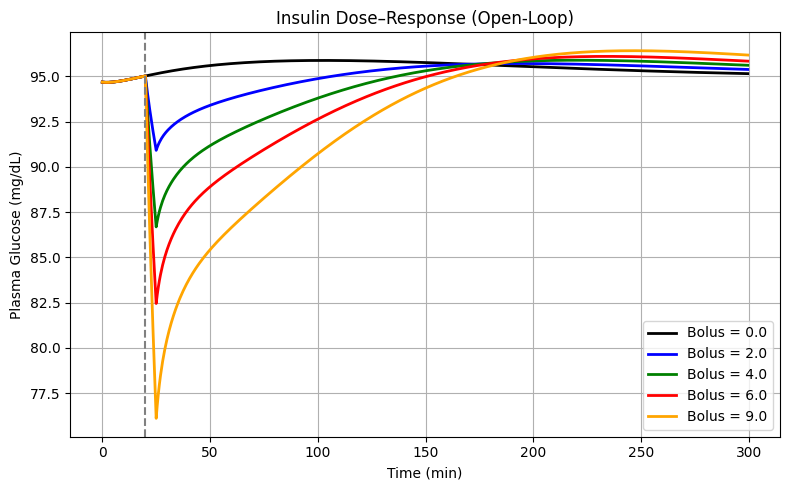

In [ ]:
# -------- Dose–response check: insulin bolus --------

bolus_doses = [0.0, 2.0, 4.0, 6.0, 9.0]   # different insulin amuounts
colors = ['black', 'blue', 'green', 'red','orange']

plt.figure(figsize=(8, 5))

for dose, col in zip(bolus_doses, colors):

    def insulin_infusion_dose(t):
        basal = 1.0
        bolus_time = 20.0
        bolus_width = 5.0
        if bolus_time <= t <= bolus_time + bolus_width:
            return basal + dose
        return basal

    def ode_dose(t, x):
        p_mod = p.copy()
        p_mod['U_ii'] = insulin_infusion_dose(t)
        return dallaman_ode(t, x, p_mod)

    sol = solve_ivp(
        ode_dose,
        [0, 300],
        x0_fasting.copy(),
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-6
    )

    G = sol.y[0] / p['V_G']
    plt.plot(sol.t, G, color=col, linewidth=2, label=f'Bolus = {dose}')

plt.axvline(20, linestyle='--', color='gray')
plt.xlabel('Time (min)')
plt.ylabel('Plasma Glucose (mg/dL)')
plt.title('Insulin Dose–Response (Open-Loop)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


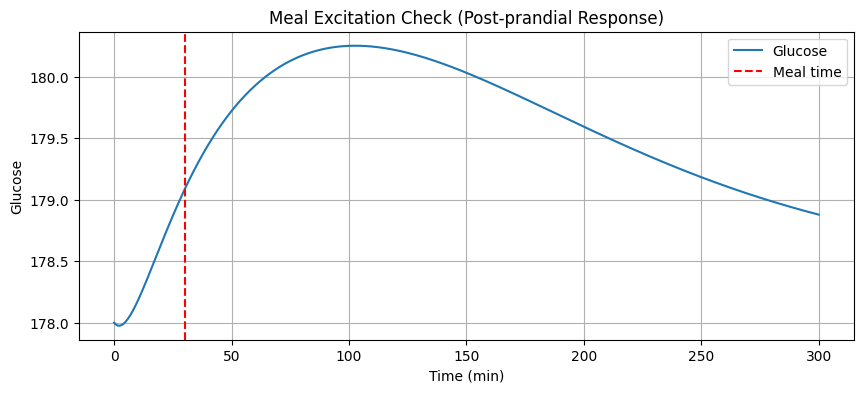

In [ ]:

# CHECK: Meal excitation (post-prandial response)

G_index = 0  # Plasma glucose
D_EPS = 1e-6  # small baseline to avoid division by zero

def meal_input(t):
    meal_time = 30.0
    meal_size = 60.0
    meal_duration = 10.0

    if meal_time <= t <= meal_time + meal_duration:
        return meal_size / meal_duration
    return 0.0


def dallaman_with_meal(t, x):
    p_mod = p.copy()
    p_mod['U_ii'] = 1.0

    D_val = meal_input(t)
    p_mod['D'] = max(D_val, D_EPS)   # <-- CRITICAL FIX

    return dallaman_ode(t, x, p_mod)


t_eval = np.linspace(0, 300, 600)
x0 = x0_fasting.copy()

sol_meal = solve_ivp(
    dallaman_with_meal,
    [t_eval[0], t_eval[-1]],
    x0,
    t_eval=t_eval
)

plt.figure(figsize=(10, 4))
plt.plot(sol_meal.t, sol_meal.y[G_index], label='Glucose')
plt.axvline(30, linestyle='--', color='r', label='Meal time')
plt.xlabel('Time (min)')
plt.ylabel('Glucose')
plt.title('Meal Excitation Check (Post-prandial Response)')
plt.legend()
plt.grid(True)
plt.show()


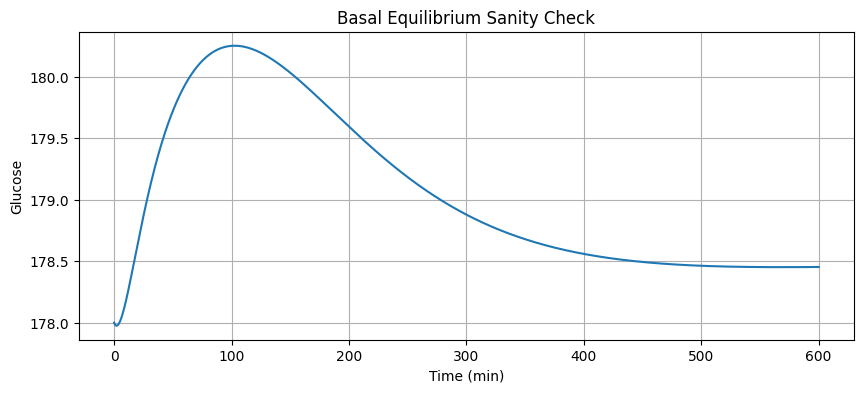

In [ ]:

#  CHECK: Basal equilibrium (no meals)

G_index=0
D_EPS = 1e-6  # same baseline

def dallaman_basal_only(t, x):
    p_mod = p.copy()
    p_mod['U_ii'] = 1.0
    p_mod['D'] = D_EPS   # <-- CRITICAL FIX
    return dallaman_ode(t, x, p_mod)


t_eval = np.linspace(0, 600, 1200)
x0 = x0_fasting.copy()

sol_basal = solve_ivp(
    dallaman_basal_only,
    [t_eval[0], t_eval[-1]],
    x0,
    t_eval=t_eval
)

plt.figure(figsize=(10, 4))
plt.plot(sol_basal.t, sol_basal.y[G_index])
plt.xlabel('Time (min)')
plt.ylabel('Glucose')
plt.title('Basal Equilibrium Sanity Check')
plt.grid(True)
plt.show()


The glucose–insulin system was implemented using the meal simulation model proposed by Dalla Man et al. (2007). All physiological parameters were fixed to the nominal values reported for the normal subject in Table I of the original paper and were not estimated or tuned in this work.

Forward simulations were conducted to verify physiological plausibility and numerical stability. In basal conditions (no meal perturbation), plasma glucose converged to a stable equilibrium, confirming correct implementation of the steady-state constraints. Following a meal perturbation introduced through the gastric compartments, plasma glucose exhibited a delayed post-prandial rise and gradual return toward basal levels, consistent with the behavior reported by Dalla Man et al.

These results validate the correctness of the forward simulator and establish a reliable baseline for subsequent sensitivity analysis and parameter estimation.

# Sensitivity analysis

In [ ]:
# ============================================================
# Stage 1A — Sensitivity Analysis (Common Helpers)
# ============================================================

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Output index: plasma glucose Gp
G_index = 0

# Parameters to analyze
param_keys = [
    'k_1','k_2','V_G',
    'k_abs','k_gri',
    'k_p1','k_p2','k_p3',
    'k_i','k_max','k_min','k_e1'
]

eps = 1e-6  # relative perturbation

def simulate_model(x0, p_local, t_eval):
    sol = solve_ivp(
        lambda t, x: dallaman_ode(t, x, p_local),
        [t_eval[0], t_eval[-1]],
        x0,
        t_eval=t_eval,
        method='RK45',
        max_step=1.0
    )
    return sol.y

def compute_normalized_sensitivity(x0, p_nom, t_eval):
    X_nom = simulate_model(x0, p_nom, t_eval)
    G_nom = X_nom[G_index, :]

    sensitivities = {}

    for key in param_keys:
        p_pert = p_nom.copy()
        delta = eps * p_nom[key] if abs(p_nom[key]) > 0 else eps
        p_pert[key] += delta

        X_pert = simulate_model(x0, p_pert, t_eval)
        G_pert = X_pert[G_index, :]

        S_norm = (p_nom[key] / G_nom) * (G_pert - G_nom) / delta
        sensitivities[key] = S_norm

    S_int = {
        k: np.trapz(np.abs(v), t_eval)
        for k, v in sensitivities.items()
    }

    return sensitivities, S_int


/tmp/ipython-input-574207951.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  k: np.trapz(np.abs(v), t_eval)



=== BASAL Sensitivity Ranking ===

     V_G : 4.5374e+02
    k_p1 : 2.4967e+02
     k_1 : 6.8410e+01
     k_2 : 6.3495e+01
    k_p2 : 3.4764e+01
    k_p3 : 2.4005e+01
     k_i : 1.8836e+00
   k_abs : 0.0000e+00
   k_gri : 0.0000e+00
   k_max : 0.0000e+00
   k_min : 0.0000e+00
    k_e1 : 0.0000e+00


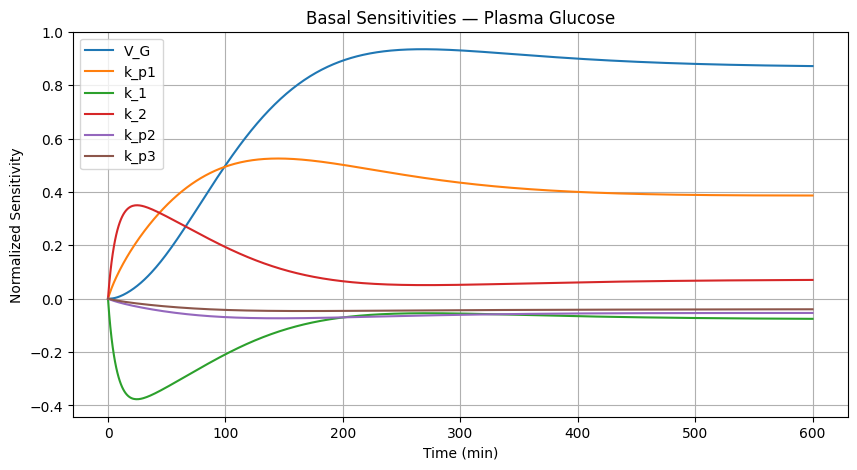

In [ ]:
# ============================================================
# Stage 1A — Basal Sensitivity (Fasting)
# ============================================================

# Time grid
t_eval_basal = np.linspace(0, 600, 601)

# Basal initial condition
x0_basal = x0_fasting.copy()

# Ensure fasting (no meal)
p_basal = p.copy()
p_basal['D'] = 1e-6  # avoid division-by-zero

sens_basal, S_int_basal = compute_normalized_sensitivity(
    x0_basal, p_basal, t_eval_basal
)

# Ranking
print("\n=== BASAL Sensitivity Ranking ===\n")
for k, v in sorted(S_int_basal.items(), key=lambda x: -x[1]):
    print(f"{k:>8s} : {v:.4e}")

# Plot top sensitivities
top_keys = sorted(S_int_basal, key=S_int_basal.get, reverse=True)[:6]

plt.figure(figsize=(10,5))
for k in top_keys:
    plt.plot(t_eval_basal, sens_basal[k], label=k)

plt.xlabel("Time (min)")
plt.ylabel("Normalized Sensitivity")
plt.title("Basal Sensitivities — Plasma Glucose")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-574207951.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  k: np.trapz(np.abs(v), t_eval)



=== MEAL Sensitivity Ranking ===

     V_G : 2.4784e+02
    k_p1 : 6.1480e+01
     k_1 : 3.3570e+01
   k_min : 3.0346e+01
     k_2 : 3.0196e+01
    k_p3 : 1.9024e+01
   k_abs : 1.7739e+01
   k_gri : 1.6680e+01
     k_i : 1.4425e+01
    k_p2 : 1.0303e+01
   k_max : 8.7646e+00
    k_e1 : 0.0000e+00


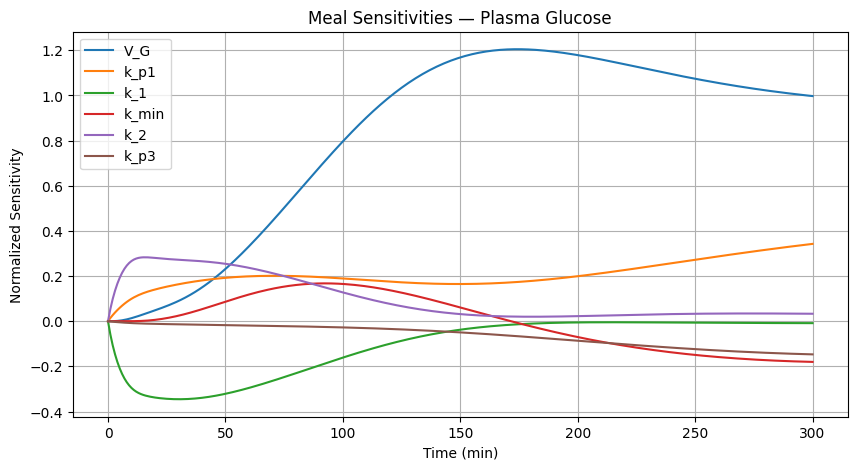

In [ ]:
# ============================================================
# Stage 1A — Meal Sensitivity (Post-prandial)
# ============================================================

# Time grid
t_eval_meal = np.linspace(0, 300, 301)

# Meal initial condition (Dalla Man–consistent)
x0_meal = x0_fasting.copy()
x0_meal[4] = 78000.0  # Qsto1 meal load

p_meal = p.copy()
p_meal['D'] = max(p.get('D', 78000.0), 1e-6)

sens_meal, S_int_meal = compute_normalized_sensitivity(
    x0_meal, p_meal, t_eval_meal
)

# Ranking
print("\n=== MEAL Sensitivity Ranking ===\n")
for k, v in sorted(S_int_meal.items(), key=lambda x: -x[1]):
    print(f"{k:>8s} : {v:.4e}")

# Plot top sensitivities
top_keys = sorted(S_int_meal, key=S_int_meal.get, reverse=True)[:6]

plt.figure(figsize=(10,5))
for k in top_keys:
    plt.plot(t_eval_meal, sens_meal[k], label=k)

plt.xlabel("Time (min)")
plt.ylabel("Normalized Sensitivity")
plt.title("Meal Sensitivities — Plasma Glucose")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ============================================================
# Stage 1A — Multi-Excitation Sensitivity
# ============================================================

import pandas as pd

# Define excitation scenarios (meal sizes in model units)
EXCITATIONS = {
    "small_meal": 30000.0,
    "large_meal": 90000.0,
}

t_eval = np.linspace(0, 300, 301)

S_tables = []

for name, meal_size in EXCITATIONS.items():
    # Initial condition
    x0 = x0_fasting.copy()
    x0[4] = meal_size  # Qsto1

    # Parameters
    p_case = p.copy()
    p_case['D'] = meal_size

    _, S_int = compute_normalized_sensitivity(x0, p_case, t_eval)

    S_tables.append(pd.Series(S_int, name=name))

# Combine into DataFrame
df_multi = pd.concat(S_tables, axis=1)
df_multi["robust_mean"] = df_multi.mean(axis=1)

# Sort by robust importance
df_multi = df_multi.sort_values("robust_mean", ascending=False)

df_multi


/tmp/ipython-input-574207951.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  k: np.trapz(np.abs(v), t_eval)


,small_meal,large_meal,robust_mean
V_G,217.351868,252.587181,234.969525
k_p1,88.904474,57.886711,73.395593
k_1,41.390983,32.153949,36.772466
k_2,37.476293,29.065036,33.270664
k_min,14.942715,33.536350,24.239532
k_p3,13.433568,20.713963,17.073766
k_abs,8.510089,19.497666,14.003877
k_gri,7.774983,18.483312,13.129148
k_p2,14.249187,9.615125,11.932156
k_i,6.764277,16.204429,11.484353


In [ ]:
# ============================================================
# Stage 1A — Window-Length Sensitivity
# ============================================================

WINDOWS = [25, 60, 120]  # minutes

meal_size = 90000.0
x0 = x0_fasting.copy()
x0[4] = meal_size

p_case = p.copy()
p_case['D'] = meal_size

window_results = {}

for Tw in WINDOWS:
    t_eval = np.linspace(0, Tw, Tw + 1)
    _, S_int = compute_normalized_sensitivity(x0, p_case, t_eval)
    window_results[f"{Tw}min"] = S_int

df_windows = pd.DataFrame(window_results)

# Sort by longest window (slow dynamics emphasis)
df_windows = df_windows.sort_values("120min", ascending=False)

df_windows


/tmp/ipython-input-574207951.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  k: np.trapz(np.abs(v), t_eval)


,25min,60min,120min
V_G,0.657290,7.189463,50.087797
k_1,6.771979,18.259231,29.576410
k_2,5.819862,14.707249,23.488668
k_p1,2.463658,8.407730,18.715430
k_min,0.077847,2.466998,12.209475
k_abs,2.502976,7.303784,9.630146
k_gri,1.934893,5.145390,7.071522
k_max,1.897201,4.060965,5.264703
k_p2,0.374032,1.557589,4.064738
k_p3,0.205711,0.737133,2.232608


/tmp/ipython-input-574207951.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  k: np.trapz(np.abs(v), t_eval)
/tmp/ipython-input-974805967.py:21: RuntimeWarning: invalid value encountered in divide
  S_norm = S_mat / np.linalg.norm(S_mat, axis=1, keepdims=True)


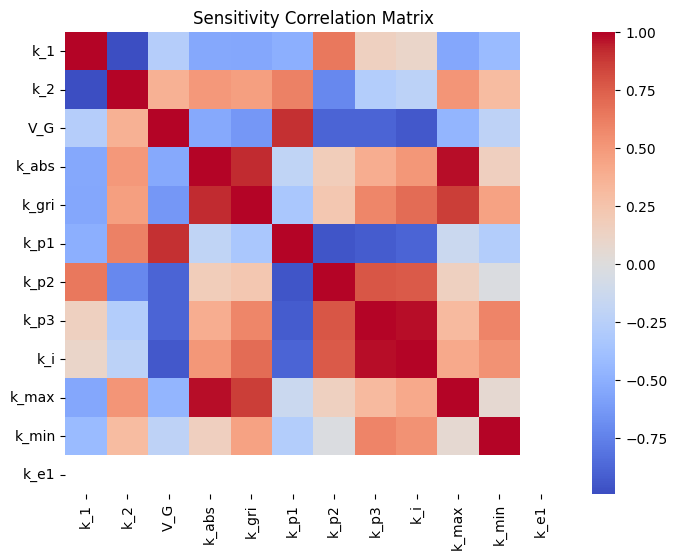

In [ ]:
# ============================================================
# Stage 1A — Sensitivity Correlation Matrix
# ============================================================

# Choose a representative excitation (large meal)
meal_size = 90000.0
t_eval = np.linspace(0, 300, 301)

x0 = x0_fasting.copy()
x0[4] = meal_size

p_case = p.copy()
p_case['D'] = meal_size

sens_time, _ = compute_normalized_sensitivity(x0, p_case, t_eval)

# Stack sensitivities into matrix: [param x time]
S_mat = np.array([sens_time[k] for k in param_keys])

# Normalize each sensitivity vector
S_norm = S_mat / np.linalg.norm(S_mat, axis=1, keepdims=True)

# Correlation matrix
C = S_norm @ S_norm.T

# Put into DataFrame for readability
df_corr = pd.DataFrame(C, index=param_keys, columns=param_keys)

df_corr


import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df_corr, cmap="coolwarm", center=0)
plt.title("Sensitivity Correlation Matrix")
plt.show()


# FIM analsyis

In [ ]:
# ============================================================
# Stage 1B — Fisher Information Matrix (FIM)
# ============================================================

import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Identification setup
# ------------------------------------------------------------

# Selected parameters (after correlation-based reduction)
theta_keys = ['V_G', 'k_1', 'k_p1', 'k_abs', 'k_i']

# Large meal, long window
meal_size = 90000.0
t_eval = np.linspace(0, 120, 121)

x0 = x0_fasting.copy()
x0[4] = meal_size

p_case = p.copy()
p_case['D'] = meal_size

# ------------------------------------------------------------
# Get time-resolved sensitivities
# ------------------------------------------------------------

sens_time, _ = compute_normalized_sensitivity(x0, p_case, t_eval)

# Build sensitivity matrix S(t): [time x parameters]
S = np.vstack([sens_time[k] for k in theta_keys]).T  # shape: (T, n_params)

# ------------------------------------------------------------
# Fisher Information Matrix
# ------------------------------------------------------------

# Assume unit noise variance (can be changed later)
W = np.eye(len(t_eval))

# FIM = ∫ Sᵀ S dt  (numerical integration)
FIM = np.trapz(S.T @ S, t_eval, axis=2) if False else np.trapz(
    np.einsum('ti,tj->tij', S, S), t_eval, axis=0
)

FIM_df = pd.DataFrame(FIM, index=theta_keys, columns=theta_keys)
FIM_df


/tmp/ipython-input-574207951.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  k: np.trapz(np.abs(v), t_eval)
/tmp/ipython-input-3906484976.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  FIM = np.trapz(S.T @ S, t_eval, axis=2) if False else np.trapz(


,V_G,k_1,k_p1,k_abs,k_i
V_G,34.727375,-9.655662,8.468617,-0.452397,-0.876916
k_1,-9.655662,8.152609,-4.678661,-2.324787,0.189017
k_p1,8.468617,-4.678661,3.074456,0.935714,-0.187682
k_abs,-0.452397,-2.324787,0.935714,1.217404,0.033341
k_i,-0.876916,0.189017,-0.187682,0.033341,0.023261


In [ ]:
# ============================================================
# Eigenanalysis of FIM
# ============================================================

eigvals, eigvecs = np.linalg.eigh(FIM)

# Sort descending
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# Display eigenvalues
eig_table = pd.DataFrame({
    "eigenvalue": eigvals,
}, index=[f"mode_{i+1}" for i in range(len(eigvals))])

eig_table


,eigenvalue
mode_1,40.324094
mode_2,6.758615
mode_3,0.093953
mode_4,0.018353
mode_5,0.000090


# Identifiability analysis

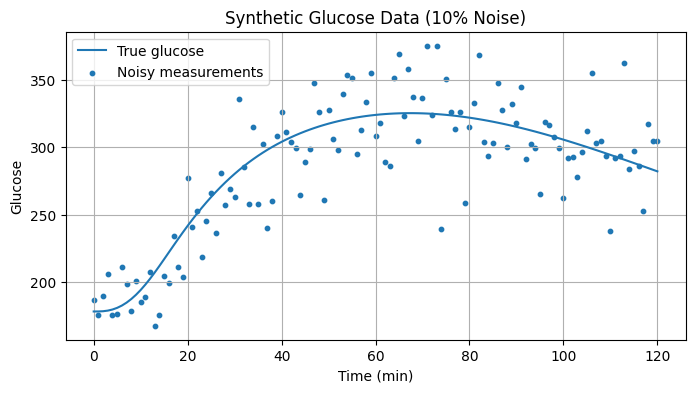

In [ ]:
# ============================================================
# Profile Likelihood — Synthetic Data Generation
# ============================================================

np.random.seed(42)

# Time window (long, to capture slow dynamics)
t_eval = np.linspace(0, 120, 121)

# Large meal experiment
x0 = x0_fasting.copy()
x0[4] = 90000.0  # meal

p_true = p.copy()
p_true['D'] = 90000.0

# Simulate "true" glucose
X_true = simulate_model(x0, p_true, t_eval)
G_true = X_true[G_index, :]

# Add 10% relative Gaussian noise
noise_std = 0.10
G_meas = G_true * (1 + noise_std * np.random.randn(len(G_true)))

plt.figure(figsize=(8,4))
plt.plot(t_eval, G_true, label="True glucose")
plt.scatter(t_eval, G_meas, s=10, label="Noisy measurements")
plt.xlabel("Time (min)")
plt.ylabel("Glucose")
plt.legend()
plt.title("Synthetic Glucose Data (10% Noise)")
plt.grid(True)
plt.show()

In [ ]:
# ============================================================
# Profile Likelihood — Chi-square Loss
# ============================================================

sigma = noise_std * G_meas  # heteroscedastic noise

theta_keys = ['V_G', 'k_1', 'k_p1', 'k_abs', 'k_i']

def chi2_loss(theta_vec, fixed_param=None, fixed_value=None):
    p_test = p.copy()
    p_test['D'] = 90000.0

    # assign free parameters
    idx = 0
    for k in theta_keys:
        if k == fixed_param:
            p_test[k] = fixed_value
        else:
            p_test[k] = 10 ** theta_vec[idx]  # log10-space
            idx += 1

    X = simulate_model(x0, p_test, t_eval)
    G_sim = X[G_index, :]

    return np.sum(((G_meas - G_sim) / sigma) ** 2)

In [ ]:
# ============================================================
# Profile Likelihood — Multi-start Optimizer
# ============================================================

from scipy.optimize import minimize

def multistart_optimize(fixed_param=None, fixed_value=None, n_starts=5):
    best_loss = np.inf
    best_theta = None

    free_keys = [k for k in theta_keys if k != fixed_param]

    for _ in range(n_starts):
        init = []
        for k in free_keys:
            init.append(np.log10(p[k]) + np.random.uniform(-0.5, 0.5))

        res = minimize(
         chi2_loss,
         init,
         args=(fixed_param, fixed_value),
         method="L-BFGS-B",
         options={"maxiter": 150}
         )


        if res.fun < best_loss:
            best_loss = res.fun
            best_theta = res.x

    return best_loss, best_theta

In [ ]:
# ============================================================
# Profile Likelihood — k_i
# ============================================================

logki_vals = np.linspace(
    np.log10(p['k_i']) - 2,
    np.log10(p['k_i']) + 2,
    12
)

chi2_profile_ki = []

for val in logki_vals:
    loss, _ = multistart_optimize(
        fixed_param='k_i',
        fixed_value=10 ** val
    )
    chi2_profile_ki.append(loss)

chi2_profile_ki = np.array(chi2_profile_ki)
delta_chi2_ki = chi2_profile_ki - np.min(chi2_profile_ki)

plt.figure(figsize=(7,4))
plt.plot(logki_vals, delta_chi2_ki, marker='o')
plt.axhline(3.84, color='r', linestyle='--', label="95% CI threshold")
plt.xlabel("log10(k_i)")
plt.ylabel("Δχ²")
plt.title("Profile Likelihood for k_i")
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
# ============================================================
# Profile Likelihood — Single-start Optimizer (for k_abs only)
# ============================================================

from scipy.optimize import minimize

def singlestart_optimize(fixed_param=None, fixed_value=None):
    free_keys = [k for k in theta_keys if k != fixed_param]

    init = []
    for k in free_keys:
        init.append(np.log10(p[k]))  # start from nominal (log-space)

    res = minimize(
        chi2_loss,
        init,
        args=(fixed_param, fixed_value),
        method="L-BFGS-B",
        options={"maxiter": 120}
    )

    return res.fun, res.x


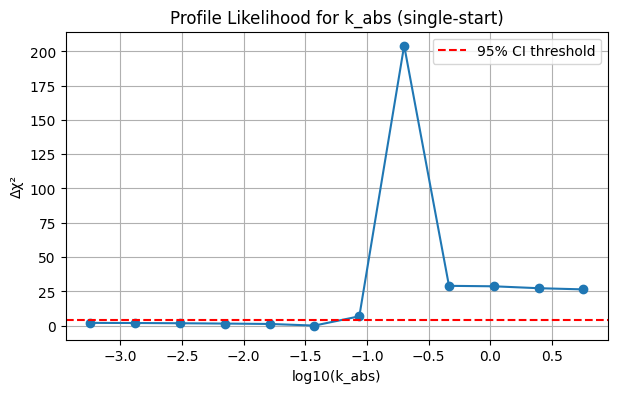

In [ ]:
# ============================================================
# Profile Likelihood — k_abs (FAST, single-start)
# ============================================================

logkabs_vals = np.linspace(
    np.log10(p['k_abs']) - 2,
    np.log10(p['k_abs']) + 2,
    12
)

chi2_profile_kabs = []

for val in logkabs_vals:
    loss, _ = singlestart_optimize(
        fixed_param='k_abs',
        fixed_value=10 ** val
    )
    chi2_profile_kabs.append(loss)

chi2_profile_kabs = np.array(chi2_profile_kabs)
delta_chi2_kabs = chi2_profile_kabs - np.min(chi2_profile_kabs)

plt.figure(figsize=(7,4))
plt.plot(logkabs_vals, delta_chi2_kabs, marker='o')
plt.axhline(3.84, color='r', linestyle='--', label="95% CI threshold")
plt.xlabel("log10(k_abs)")
plt.ylabel("Δχ²")
plt.title("Profile Likelihood for k_abs (single-start)")
plt.legend()
plt.grid(True)
plt.show()


# Reduced-Order Modeling (ROM)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================
# TEST 1: Empirical Input–Output Energy Analysis (Nonlinear ROM)
# ============================================================

def test_input_output_energy():
    """
    Empirical controllability–observability energy analysis
    for nonlinear Dalla Man model.

    Does NOT modify original model.
    Uses physiologically meaningful inputs only.
    """

    # --------------------------------------------------------
    # Baseline model
    # --------------------------------------------------------
    _, p_base, x0 = run_simulation(t_span=(0, 1), dt=1.0)

    t_span = (0, 300)          # 5 hours
    t_eval = np.linspace(*t_span, 1200)

    n_states = len(x0)

    state_names = [
        'Gp', 'Gt', 'Il', 'Ip', 'Q_sto1', 'Q_sto2',
        'Q_gut', 'I1', 'Id', 'X', 'I_po', 'Y'
    ]

    # --------------------------------------------------------
    # 1️⃣ Insulin impulse experiment
    # --------------------------------------------------------
    def insulin_impulse(t):
        return 10.0 if 10 <= t <= 15 else p_base['U_ii']

    def ode_insulin(t, x):
        p = p_base.copy()
        p['U_ii'] = insulin_impulse(t)
        return dallaman_ode(t, x, p)

    sol_ins = solve_ivp(
        ode_insulin, t_span, x0, t_eval=t_eval,
        atol=1e-6, rtol=1e-6
    )

    # --------------------------------------------------------
    # 2️⃣ Meal impulse experiment
    # --------------------------------------------------------
    def meal_impulse(t):
        return 1e4 if 10 <= t <= 15 else 0.0  # small meal impulse

    def ode_meal(t, x):
        p = p_base.copy()
        p['D'] = p_base['D'] + meal_impulse(t)
        return dallaman_ode(t, x, p)

    sol_meal = solve_ivp(
        ode_meal, t_span, x0, t_eval=t_eval,
        atol=1e-6, rtol=1e-6
    )

    # --------------------------------------------------------
    # 3️⃣ Empirical controllability energy
    # --------------------------------------------------------
    Wc = np.zeros(n_states)

    for i in range(n_states):
        Wc[i] = (
            np.trapz(sol_ins.y[i]**2, t_eval) +
            np.trapz(sol_meal.y[i]**2, t_eval)
        )

    # --------------------------------------------------------
    # 4️⃣ Empirical observability energy
    # --------------------------------------------------------
    glucose = sol_ins.y[0]  # Gp output
    Wo = np.zeros(n_states)

    for i in range(n_states):
        Wo[i] = np.trapz((sol_ins.y[i] * glucose)**2, t_eval)

    # --------------------------------------------------------
    # 5️⃣ Joint state influence
    # --------------------------------------------------------
    influence = np.sqrt(Wc * Wo)
    influence /= np.max(influence)

    ranked_idx = np.argsort(influence)[::-1]

    # --------------------------------------------------------
    # 6️⃣ Print results
    # --------------------------------------------------------
    print("\n" + "="*70)
    print("TEST 1 — Empirical Input–Output Energy Ranking")
    print("="*70)
    print(f"{'Rank':<5} {'State':<8} {'Influence':<10}")
    print("-"*40)

    for r, idx in enumerate(ranked_idx):
        print(f"{r+1:<5} {state_names[idx]:<8} {influence[idx]:.4f}")

    # --------------------------------------------------------
    # 7️⃣ Plot
    # --------------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.bar(
        range(n_states),
        influence[ranked_idx]
    )
    plt.xticks(
        range(n_states),
        [state_names[i] for i in ranked_idx],
        rotation=45
    )
    plt.ylabel("Normalized Influence")
    plt.title("State Importance for ROM (Empirical Energy)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return influence, ranked_idx


In [ ]:
influence, ranked_idx = test_input_output_energy()


ValueError: not enough values to unpack (expected 3, got 2)

#

#

#